## SEO Dashboard with Google Analytics Data

This report explores how we can pull in website data from Google Analytics and find insights on SEO. If you want to run this notebook, the install & setup instructions are kept [in the Readme.md](/Readme.md).

### Introduction

Google Analytics is a website traffic analysis application that provides real-time statistics and analysis of user interaction with the website. Google analytics enables website owners to analyze their visitors, with the objective of interpreting and optimizing website's performance.

In this report we will learn how to pull in the data using the Google Analytics Reporting API and graph some interesting SEO metrics to show meaningful insights for an online educational platform that has been running  an extensive content marketing campaign for the last 18 months in order to drive more traffic to their website.

First let's import the libraries we will require:

In [1]:
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
import httplib2
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize

import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
from cufflinks import tools

### Create Globsal Variables For Data Access

If you haven't already, check out the Readme.md file on this repository for instructions on how to creeate a project in the Google API Console, to enable the API, and create the key file, which you should save to this directory as *client_secrets.json*

**Remeber to add the _client_secrets.json_ file to your .gitignore!**

Replace the VIEW_ID value below with your own. You can use the [Account Explorer](https://ga-dev-tools.appspot.com/account-explorer/) to find your View ID.

In [1]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'client_secrets.json'
VIEW_ID = 'XXXXXXX'

### Fetching Our Data

Below we are initializing an Analytics Reporting API V4 service object with our credentials created above, defining our queries to the Google Analytics API and returning its response.

In [3]:
organic_query = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2020-05-01'}],
                'metrics': [{'expression': 'ga:sessions'}], 
                'dimensions': [{"name":"ga:yearmonth"}], 
                'filtersExpression':'ga:medium=~organic'
            }

nonorganic_query = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2020-05-01'}],
                'metrics': [{'expression': 'ga:sessions'}], 
                'dimensions': [{"name":"ga:yearmonth"}], 
                'filtersExpression':'ga:medium!=~(none)'
            }

top_landing_pages_query = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2020-05-01'}],
                'metrics': [{'expression': 'ga:pageviews'},
                            {'expression': 'ga:avgSessionDuration'},
                           {'expression': 'ga:bounceRate'}], 
                'dimensions': [{"name":"ga:landingPagePath"}],
                'orderBys': [{"fieldName": "ga:pageviews", "sortOrder": "DESCENDING"}], 
            }

credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
analytics = build('analyticsreporting', 'v4', credentials=credentials)

In [4]:
response = analytics.reports().batchGet( body={ 
    'reportRequests': [
        organic_query,
        nonorganic_query,
        top_landing_pages_query
    ] 
} ).execute();

***

#### Note

The [Google Analytics Metric and Dimension Explorer](https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/) is a great resource to use when searching for the dimensions and metrics you want to visualize, which will largely depend on your business and your digital marketing strategy.
***

### Manipulating Our Data

Now let's parse the JSON response returend from our queries defined in the previous step into pandas dataframes, which will make it much easier to manipulate and graph the data.

In [9]:
df_sessions = pd.DataFrame({
    'Date': [x['dimensions'][0] for x in response['reports'][0]['data']['rows']],
    'Organic Sessions': [x['metrics'][0]['values'][0] for x in response['reports'][0]['data']['rows']],
    'Direct Traffic': [x['metrics'][0]['values'][0] for x in response['reports'][1]['data']['rows']],
})

df_sessions['Date'] = df_sessions['Date'].str.slice(0,4) + '-' + df_sessions['Date'].str.slice(4,6)
df_sessions = df_sessions.astype({ 'Organic Sessions': int, 'Direct Traffic': int})

df_landing_pages = pd.DataFrame({
    'Landing Page': [x['dimensions'][0] for x in response['reports'][2]['data']['rows']],
    'Page Views': [x['metrics'][0]['values'][0] for x in response['reports'][2]['data']['rows']],
    'Avg Session Duration': [x['metrics'][0]['values'][1] for x in response['reports'][2]['data']['rows']],
    'Bounce Rate': [x['metrics'][0]['values'][2] for x in response['reports'][2]['data']['rows']],
})

df_landing_pages = df_landing_pages.astype({ 'Page Views': int, 'Avg Session Duration': float, 'Bounce Rate': float})

### Caching Our Data

Let's save everything to cache file so we dont need to download all the time. This is also handy to save data for APIs that have historical limits.

In [10]:
with open('cache/sessions.json', 'w') as f:
    f.write(df_sessions.to_json(indent=2))
    
with open('cache/landing_pages.json', 'w') as f:
    f.write(df_landing_pages.to_json(indent=2))

In [11]:
df_sessions = pd.read_json('cache/sessions.json').set_index('Date')
df_landing_pages = pd.read_json('cache/landing_pages.json')

### Has Our Organic Traffic Improved Over Time?

Let's visualize the progression of both organic and all other traffic to the website through time.

<ipython-input-17-4de9f68db379>:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



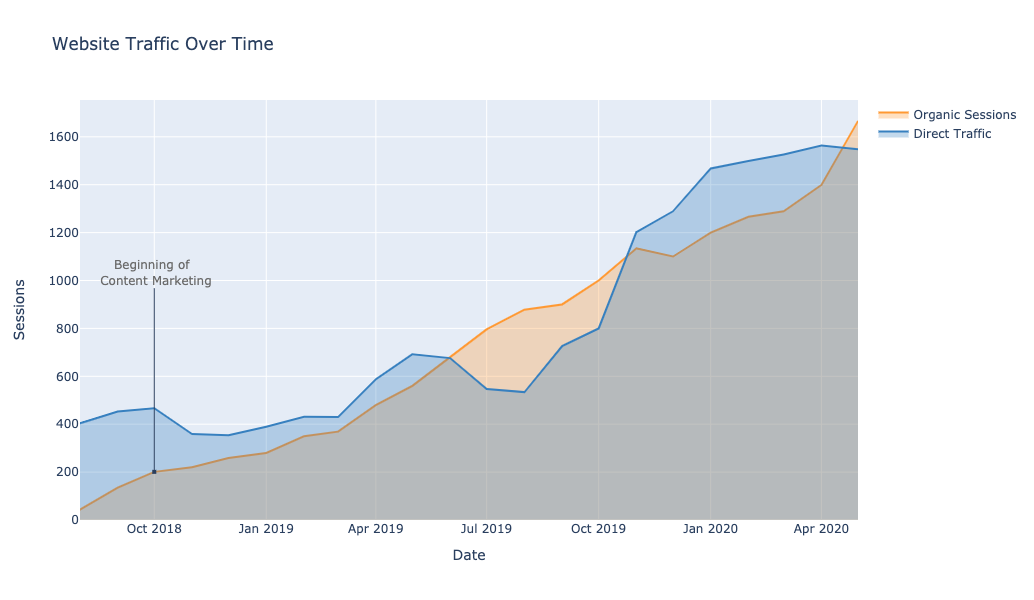

In [17]:
layout = cf.Layout(
    height = 600,
    width = 800,
    yaxis = dict(
    title = 'Sessions'),
    xaxis = dict(
    title = 'Date'),
    title = 'Website Traffic Over Time'
)

fig = df_sessions.groupby(['Date'],as_index=True)['Organic Sessions','Direct Traffic'].mean().\
    iplot(kind='scatter',
          fill=True,
          width=2,
          asFigure=True,
          layout = layout)

fig.layout.annotations = [
        dict(
            x='2018-10',
            y='201',
            text='Beginning of <br> Content Marketing',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-200,
            font=dict(
            size=12,
            color='rgb(107, 107, 107)'
            )
        )
]

fig.show()

### Where Does This Search Result Traffic Land?

- This company creates lots of different types of content to drive traffic to the website.
- We want to know not only what pieces of content are getting the most results but also the type of content that is most successful.
- Let's pull in the data we need to answer this question. We will look at the top 10 landing pages by pageviews, along with their bounce rates and average session durations.

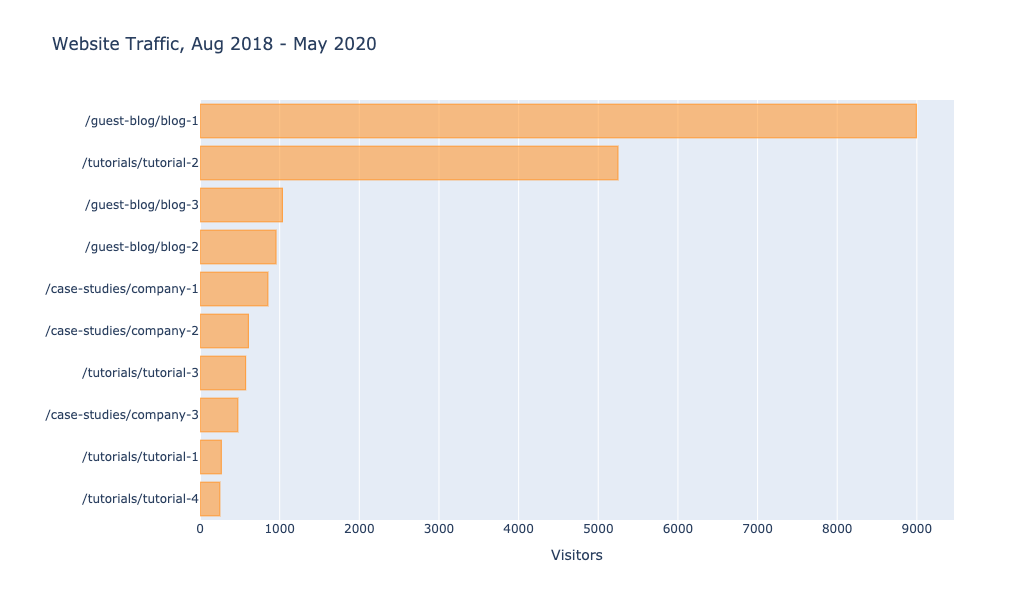

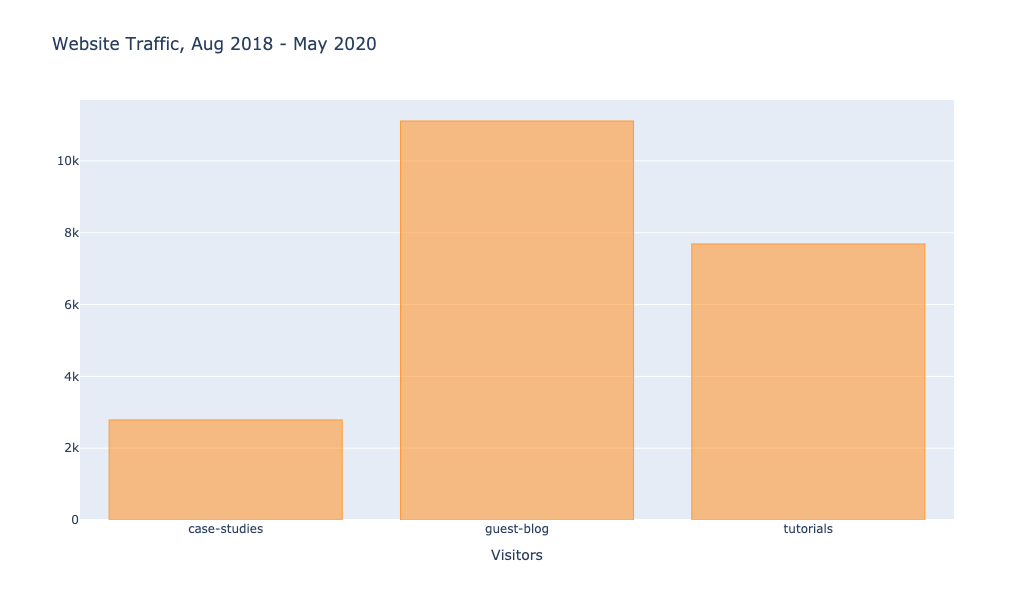

In [18]:
temp_df = df_landing_pages.groupby(['Landing Page'],as_index=True)['Page Views'].mean().sort_values(ascending=False)[1:].head(10)

layout = cf.Layout(
    height = 600,
    width = 800,
    xaxis = dict(title = 'Visitors'),
    title = 'Website Traffic, Aug 2018 - May 2020'
)

fig = temp_df.sort_values().\
    iplot(asFigure=True,
          kind = 'barh',
         layout=layout)
    
fig.update_layout(
    margin=dict(l=200),
)

fig.show()

df_content_type = df_landing_pages
df_content_type['Landing Page'] = df_content_type['Landing Page'].str.rsplit('/',expand=True)[1]
df_content_type = df_content_type.iloc[1:]
df_content_type = pd.DataFrame(df_content_type.groupby(['Landing Page'],as_index=True)['Page Views'].sum())
df_content_type.iplot(asFigure=True,layout=layout, kind='bar')

- We can see that guest blogs drive the most traffic overall.
- However, this might be because there are simply more of these articles being published than *Tutorials* or *Case Studies*.

### What Is The Quality Of The Content?

- One way to proxy this is to calculate the distribution of session duration and bounce rates across our different types of landing pages.
- We already have the data available so let's go straight into plotting.

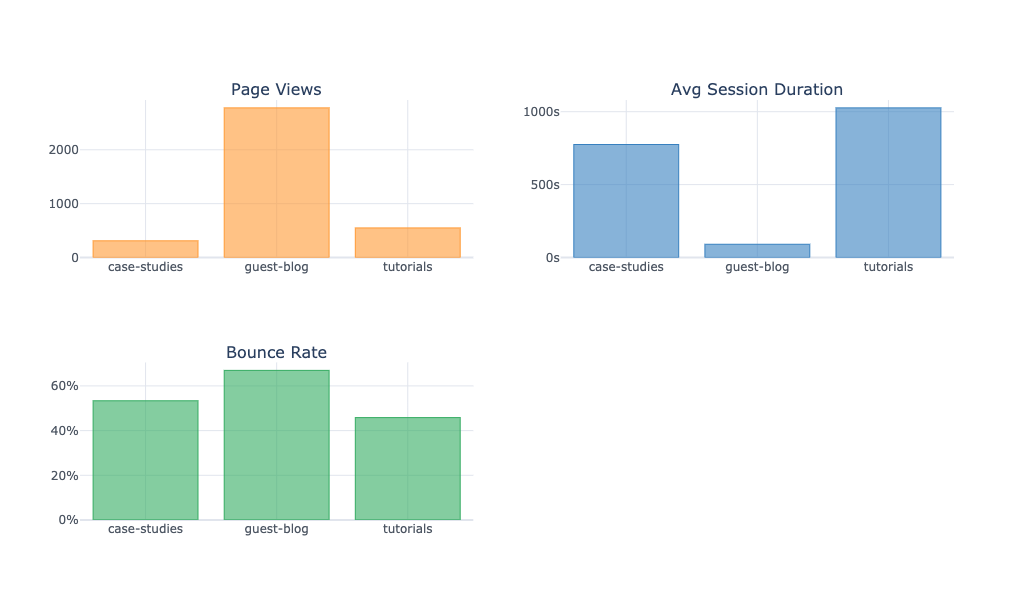

In [19]:
layout = cf.Layout(
    height = 600,
    width = 800,
    title = 'Measuring Quality of Content'
)

fig = df_landing_pages[1:].groupby('Landing Page')[['Page Views','Avg Session Duration','Bounce Rate']].mean().iplot(asFigure=True, kind='bar', 
                                                                                              subplots=True, subplot_titles=True, 
                                                                                                    legend=False)

fig.layout.height = 600
fig.layout.width = 800
fig.layout.template = 'plotly'

fig.layout.yaxis2.ticksuffix = 's'
fig.layout.yaxis3.ticksuffix = '%'

fig.show()

* Indeed, we can see that, while guest blogs do receive much more eyeballs, the average session duration for this content is by far the lowest, and its avergae bounce rate is also the highest.
* Tutorials seem to be the most valuable content to their readers according to these metrics.
* Given the fact that guest blogs typically require payment of some kind, this company should seriously consider investing a lot more time and effort into case studies and tutorials.